# Clean collected data
per serving and per recipe

including merge, remove nan, remove outliers, re-download images, train-test split...

In [1]:
import re
import os
import ast
import shutil
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

## merge images and csv files from two sources
add 'calorie' as a new column

In [5]:
def remove_nan_calorie_rows(csv_file):
    # delete rows without annotated calorie value
    calorie_list = []
    nan_calorie_list = []
    for (i, value) in enumerate(csv_file['nutrients']):
        # the format of nutrient is different in the two datasets
        if (csv_file['file_name'][i].startswith('kitchen')) == True:
            try:
                calorie_list.append(int(ast.literal_eval(value)['Calories ']))
            except:
                nan_calorie_list.append(i)
        else:
            try:
                calorie_list.append(int(re.findall('\d+', ast.literal_eval(value)['calories'])[0]))
            except:
                nan_calorie_list.append(i)
    
    csv_file = csv_file.drop(nan_calorie_list)
    csv_file['calorie'] = calorie_list
    #csv_file = csv_file.drop('image', axis=1)
    return csv_file


# store in csv file first to make the index consistent
train1 = pd.read_csv('./data/bbc_train.csv')
train2 = pd.read_csv('./data/kitchen_train.csv')
train = train1.append(train2)

test1 = pd.read_csv('./data/bbc_test.csv')
test2 = pd.read_csv('./data/kitchen_test.csv')
test = test1.append(test2)

train.to_csv('./data/train.csv', index=False)
test.to_csv('./data/test.csv', index=False)

# read merged csv file and remove rows with NaN calories
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
print(len(train))
print(len(test))

train = remove_nan_calorie_rows(train)
test = remove_nan_calorie_rows(test)
train.to_csv('./data/train.csv', index=False)
test.to_csv('./data/test.csv', index=False)
print(len(train))
print(len(test))

all_data = pd.read_csv('./data/train.csv').append(pd.read_csv('./data/test.csv'))
all_data.to_csv('./data/all_data.csv', index=False)

7773
1372
7761
1370


In [2]:
all_data = pd.read_csv('./data/all_data.csv')
print(len(all_data))
all_data.head()

9131


,title,image,ingredients,nutrients,file_name,category,serving,url,source,calorie
0,Easy bread rolls,https://images.immediate.co.uk/production/vola...,"['500g strong white bread flour , plus extra f...","{'calories': '246 calories', 'fatContent': '2 ...",bread0.jpg,bread,8.0,https://www.bbcgoodfood.com/recipes/Easy-bread...,bbc,246
1,Vegan banana bread,https://images.immediate.co.uk/production/vola...,"['3 large black bananas', '75ml vegetable oil ...","{'calories': '218 calories', 'fatContent': '8 ...",bread1.jpg,bread,10.0,https://www.bbcgoodfood.com/recipes/Vegan-bana...,bbc,218
2,Meatball & garlic bread traybake,https://images.immediate.co.uk/production/vola...,"['350g turkey thigh mince', '1 tsp dried orega...","{'calories': '565 calories', 'fatContent': '28...",bread2.jpg,bread,3.0,https://www.bbcgoodfood.com/recipes/Meatball-&...,bbc,565
3,Naan bread,https://images.immediate.co.uk/production/vola...,"['1x 7g sachet dried yeast', '2 tsp golden cas...","{'calories': '224 calories', 'fatContent': '8 ...",bread3.jpg,bread,8.0,https://www.bbcgoodfood.com/recipes/Naan-bread,bbc,224
4,Pitta bread,https://images.immediate.co.uk/production/vola...,"['2 tsp fast-action dried yeast', '500g strong...","{'calories': '246 calories', 'fatContent': '2 ...",bread4.jpg,bread,8.0,https://www.bbcgoodfood.com/recipes/Pitta-bread,bbc,246


In [3]:
all_data.describe()

,serving,calorie
count,9075.000000,9131.000000
mean,8.164408,423.973168
std,28.506662,284.912564
min,0.000000,0.000000
25%,4.000000,260.000000
50%,4.000000,385.000000
75%,8.000000,544.500000
max,850.000000,7865.000000


Text(0.5, 1, 'Distrubution of Calories in raw dataset (per serving)')

<Figure size 720x360 with 0 Axes>

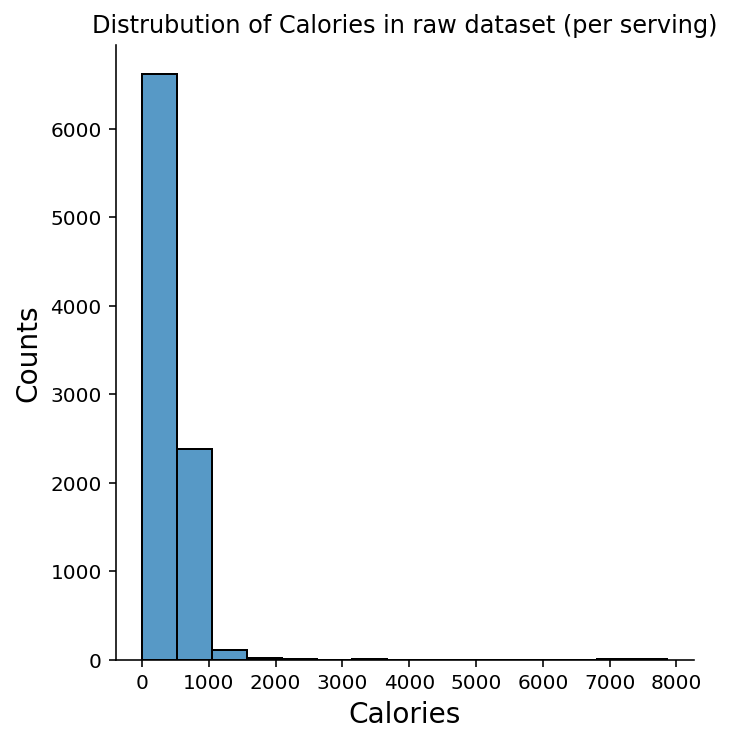

In [14]:
plt.figure(figsize=(10,5))
sns.displot(all_data['calorie'], bins = 15)
#plt.bar(appliances, height=10)

plt.xlabel('Calories', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.title('Distrubution of Calories in raw dataset (per serving)', y=1)
#plt.grid()

In [23]:
all_data[6124:6125]

,title,image,ingredients,nutrients,file_name,category,serving,url,source,calorie,calorie_per_recipe
6124,Shrimp Pasta with White Wine Sauce,https://cdn.apartmenttherapy.info/image/fetch/...,['1 pound peeled and cooked medium shrimp (70 ...,"{'Calories ': '7865', 'Fat ': '120.6 g (185.5%...",kitchen_pasta81.jpg,pasta,4.0,NaN,kitchen,7865,31460.0


## Per serving

## remove outliers
Since nutritional information is provided by the website/user, they are not that trustworthy. In fact, there are some calorie values which are obviously wrong, such as 1000+cal per serving or 0cal per serving. So, these outliers should be removed iteratively based on mean and standard deviation values.

In [ ]:
# remove outliers iteratively until convergence

def remove_outliers(csv_file):
    
    mean = csv_file['calorie'].mean()
    std = csv_file['calorie'].std()

    # delete those outside (mean±2*std)
    csv_file = csv_file.drop(csv_file[csv_file['calorie']>mean+2*std].index)
    csv_file = csv_file.drop(csv_file[csv_file['calorie']<mean-2*std].index)
    print(len(csv_file))
    return csv_file


last_len = 0

while last_len!=len(all_data):
    last_len = len(all_data)
    all_data = remove_outliers(all_data)
    

    all_data.to_csv('./data/all_data.csv', index=False)
all_data.describe()

### Find those NoneType images manually 
These images could be png or gif, or the scraper fails at finding the correct image.

In [ ]:
all_data = pd.read_csv('./data/all_data.csv')
len(all_data)

In [ ]:
# sort image name by number
def sort_key(s):
    try:
        c = re.findall('\d+', s)[0]
    except:
        c = -1
    return int(c)


def find_not_jpg_pics(path):
    wrong_index_list = []
    for path, subpath, files in os.walk(path):
        files.sort(key=sort_key)
        for i in files:
            if i.endswith("jpg") or i.endswith("png") or i.endswith("jp2"):
                try:
                    img = Image.open(path + "/" +i)
                except:
                    wrong_index_list.append(i)
    
    return wrong_index_list


wrong_index_list = find_not_jpg_pics('./data/all_data/')
wrong_index_list

#### go to websites to check if there are correct images of these indexes and download manually
7 images are found in this case

In [ ]:
# change the .jpg to .jp2
def correct_gif_images(csv_file, src_path, dst_path):
    name_list = list(csv_file['file_name'])
    names = os.listdir(src_path)
    for name in names:
        if name.endswith('jp2'):
            file_name = name[:-4]+'.jpg'
            try:
                os.remove(dst_path + file_name)
                shutil.copy(src_path+name, dst_path+name)
            except:
                pass
            index = name_list.index(file_name)
            csv_file['file_name'][index] = name
    
    return csv_file


all_data = correct_gif_images(all_data, './correct_image/', './data/all_data/')


In [ ]:
def remove_record_without_image(csv_file, index_list, path):
    # no replacement is found and cannot open
    for name in index_list:
        name_list = list(csv_file['file_name'])
        index = name_list.index(name)
        csv_file = csv_file.drop(index)
        print(len(csv_file))
        os.remove(path + name)
        
    # image link ends with None
    drop_list = []
    for i, v in enumerate(csv_file['image']):
        if v.endswith('None'):
            drop_list.append(i)
    csv_file = csv_file.drop(drop_list)
    print(len(csv_file))
    
    return csv_file

all_data = remove_record_without_image(all_data, wrong_index_list, './data/all_data/')
all_data.to_csv('./data/all_data_clean.csv', index=False)

### Split into 85% training set and 15% test set 

In [2]:
all_data = pd.read_csv('./data/all_data_clean.csv')

all_data[:round(len(all_data)*0.85)].to_csv('./data/per_serving/train_clean.csv', index=False)
all_data[round(len(all_data)*0.85):].to_csv('./data/per_serving/test_clean.csv', index=False)

In [3]:
all_data.describe()

,serving,calorie
count,7602.000000,7648.000000
mean,7.500000,361.438808
std,20.765873,144.304508
min,0.000000,73.000000
25%,4.000000,252.000000
50%,4.000000,349.000000
75%,8.000000,475.000000
max,850.000000,650.000000


In [ ]:
train = pd.read_csv('./data/per_serving/train_clean.csv')
for name in train['file_name']:
    try:
        shutil.move('./data/all_data/'+name, './data/per_serving/train/'+name)
    except:
        print(name)
    
test = pd.read_csv('./data/per_serving/test_clean.csv')
for name in test['file_name']:
    try:
        shutil.move('./data/all_data/'+name, './data/per_serving/test/'+name)
    except:
        print(name)

## Per recipe

In [5]:
all_data = pd.read_csv('./data/train.csv').append(pd.read_csv('./data/test.csv'))
all_data.to_csv('./data/all_data_per_recipe.csv', index=False)
all_data = pd.read_csv('./data/all_data_per_recipe.csv')
print(len(all_data))
all_data.describe()

9131


,serving,calorie
count,9075.000000,9131.000000
mean,8.164408,423.973168
std,28.506662,284.912564
min,0.000000,0.000000
25%,4.000000,260.000000
50%,4.000000,385.000000
75%,8.000000,544.500000
max,850.000000,7865.000000


Text(0.5, 1, 'Distrubution of Calories in raw dataset (per recipe)')

<Figure size 720x360 with 0 Axes>

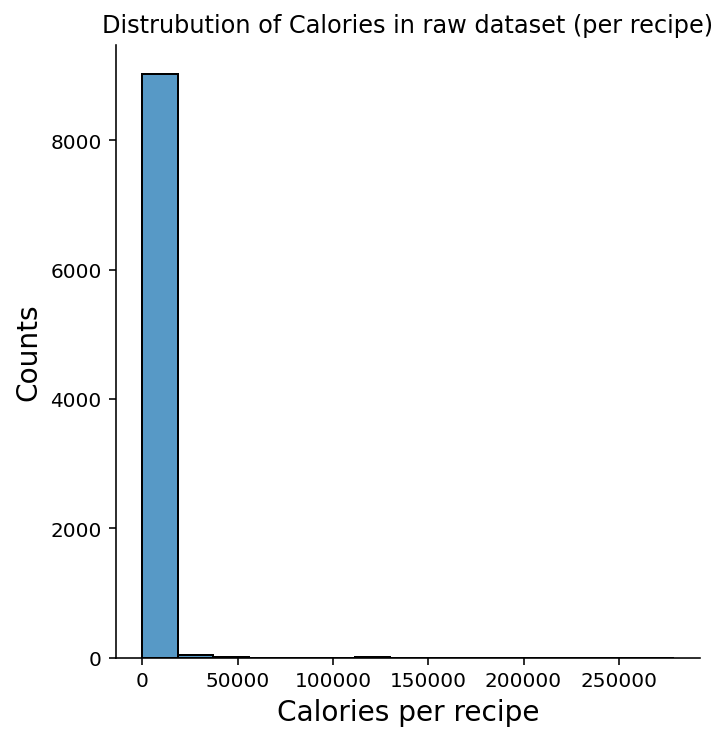

In [15]:
all_data['calorie_per_recipe'] = all_data['serving']*all_data['calorie']
all_data.describe()

plt.figure(figsize=(10,5))
sns.displot(all_data['calorie_per_recipe'], bins = 15)
#plt.bar(appliances, height=10)

plt.xlabel('Calories per recipe', fontsize = 14)
plt.ylabel('Counts', fontsize = 14)
plt.title('Distrubution of Calories in raw dataset (per recipe)', y=1)
#plt.grid()

### clean serving information

In [ ]:
# delete rows without serving information
no_serving_information = list(all_data['serving'][all_data['serving'].isnull()].index)
all_data = all_data.drop(no_serving_information)
print(len(all_data))

# delete rows with serving>30
high_serving = list(all_data['serving'][all_data['serving']>30].index)
all_data = all_data.drop(high_serving)
print(len(all_data))

# delete rows with serving==0
no_serving = list(all_data['serving'][all_data['serving']==0].index)
all_data = all_data.drop(no_serving)
print(len(all_data))
#pd.DataFrame(all_data['title'][list(all_data['serving'][all_data['serving']>30].index)]).join(pd.DataFrame(all_data['url'][list(all_data['url'][all_data['serving']>30].index)]))

In [24]:
all_data['calorie_per_recipe'] = all_data['serving']*all_data['calorie']
#all_data.head()
all_data.describe()

,serving,calorie,calorie_per_recipe
count,9075.000000,9131.000000,9075.000000
mean,8.164408,423.973168,2701.868099
std,28.506662,284.912564,4641.926437
min,0.000000,0.000000,0.000000
25%,4.000000,260.000000,1050.000000
50%,4.000000,385.000000,1878.000000
75%,8.000000,544.500000,3200.000000
max,850.000000,7865.000000,278800.000000


In [ ]:
def remove_outliers(csv_file):
    mean = csv_file['calorie_per_recipe'].mean()
    std = csv_file['calorie_per_recipe'].std()

    csv_file = csv_file.drop(csv_file[csv_file['calorie_per_recipe']>mean+2*std].index)
    csv_file = csv_file.drop(csv_file[csv_file['calorie_per_recipe']<mean-2*std].index)
    print(len(csv_file))
    return csv_file


last_len = 0
while last_len!=len(all_data):
    last_len = len(all_data)
    all_data = remove_outliers(all_data)

    
all_data.to_csv('./data/per_recipe/all_data_per_recipe_clean.csv', index=False)
all_data.describe()

### change jpg to jp2 of some pics

In [ ]:
all_data = pd.read_csv('./data/per_recipe/all_data_per_recipe_clean.csv')
print(len(all_data))

In [ ]:
def correct_gif_images(csv_file, src_path, dst_path):
    name_list = list(csv_file['file_name'])
    names = os.listdir(src_path)
    for name in names:
        if name.endswith('jp2'):
            file_name = name[:-4]+'.jpg'
            try:
                os.remove(dst_path + file_name)
                shutil.copy(src_path+name, dst_path+name)
            except:
                pass
            try:
                index = name_list.index(file_name)
                csv_file['file_name'][index] = name
            except:
                pass
    return csv_file


def remove_record_without_image(csv_file, path):
    drop_list = []
    for i, v in enumerate(csv_file['image']):
        if v.endswith('None'):
            drop_list.append(i)
    csv_file = csv_file.drop(drop_list)
    print(len(csv_file))
    
    return csv_file


all_data = correct_gif_images(all_data, './correct_image/', './data/all_data/')
all_data = remove_record_without_image(all_data, './data/all_data/')
all_data.to_csv('./data/per_recipe/all_data_per_recipe_clean.csv', index=False)

### Split into 85% training set and 15% test set 

In [ ]:
all_data = pd.read_csv('./data/per_recipe/all_data_per_recipe_clean.csv')
print(len(all_data))

all_data[:round(len(all_data)*0.85)].to_csv('./data/per_recipe/train_per_recipe_clean.csv', index=False)
all_data[round(len(all_data)*0.85):].to_csv('./data/per_recipe/test_per_recipe_clean.csv', index=False)

In [ ]:
train = pd.read_csv('./data/per_recipe/train_per_recipe_clean.csv')
for name in train['file_name']:
    try:
        shutil.copy('./data/all_data/'+name, './data/per_recipe/train/'+name)
    except:
        print(name)
    
test = pd.read_csv('./data/per_recipe/test_per_recipe_clean.csv')
for name in test['file_name']:
    try:
        shutil.copy('./data/all_data/'+name, './data/per_recipe/test/'+name)
    except:
        print(name)
    